In [53]:
from sklearn.datasets import  make_blobs
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc, accuracy_score, roc_auc_score
from sklearn.linear_model import RidgeClassifier
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import time
import pandas as pd
from sklearn.feature_selection import SequentialFeatureSelector

# Generate synthetic one modal dataset

In [2]:
X, y = make_blobs(n_samples=2502, centers=2, n_features=2, random_state=259202)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=259202)

In [3]:
X_train, y_train

(array([[ 1.74771932,  7.06026374],
        [11.63628313,  2.43832222],
        [ 7.83213125,  3.25616202],
        ...,
        [11.15319987,  2.83310227],
        [ 0.365067  ,  5.57690838],
        [11.17654856,  2.5515603 ]], shape=(2001, 2)),
 array([0, 1, 1, ..., 1, 0, 1], shape=(2001,)))

In [4]:
X_test.shape, y_test.shape

((501, 2), (501,))

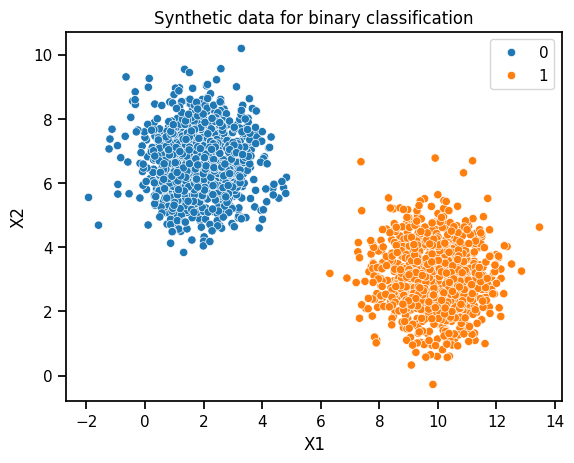

In [5]:
def plot_2d_data(X, y, title):
    sns.set_context("notebook")
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=y)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.title(title)
    plt.show()
plot_2d_data(X_train, y_train, "Synthetic data for binary classification")

Normalize the data

In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

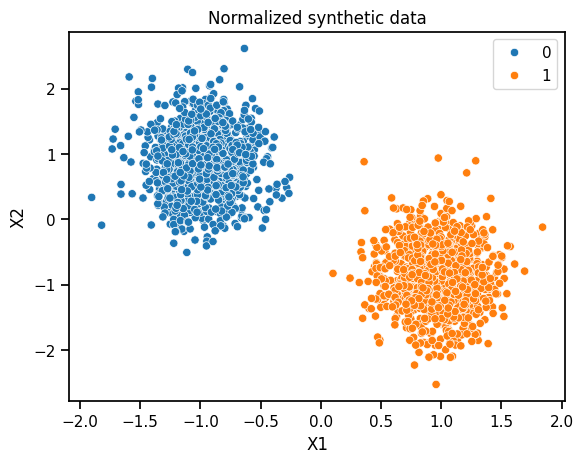

In [7]:
plot_2d_data(X_train, y_train, "Normalized synthetic data")

# Analytical linear classifier with L2 regularization

In [8]:
def analytical_linear_l2(X, y, lambda_):

    X_ = np.c_[np.ones(X.shape[0]), X] # [N, D+1]

    I = np.eye(X_.shape[1]) # [D+1, D+1]
    I_ = I*lambda_
    
    # (D+1, N) @ (N, D+1) = (D+1, D+1)  <- X_.T @ X_
    # (D+1, D+1) @ (D+1, N) = (D+1, N)  <- inv(X_.T @ X_ + I_) @ X_.T
    # (D+1, N) @ (N, 1) = (D+1, 1)      <- X_.T @ y
    w = np.linalg.inv(X_.T @ X_ + I_) @ X_.T @ y
    return w

In [9]:
w = analytical_linear_l2(X_train, y_train, 1)

In [10]:
w.shape, w

((3,), array([ 0.5014985 ,  0.41123909, -0.08663209]))

In [11]:
X_test_ = np.c_[np.ones(X_test.shape[0]), X_test]
X_test_.shape, X_test_

((501, 3),
 array([[ 1.        ,  0.8355693 , -0.99349447],
        [ 1.        , -1.45735918,  1.09345574],
        [ 1.        , -0.96687053,  0.44704932],
        ...,
        [ 1.        , -1.12383436,  0.80544164],
        [ 1.        ,  1.14406207, -1.31397891],
        [ 1.        , -0.88148021,  0.72198783]], shape=(501, 3)))

In [12]:
scores = X_test_ @ w
scores.shape, scores[:5] , X_test_[:5]

((501,),
 array([ 0.93118576, -0.19255291,  0.06515473,  1.02054516,  0.21864988]),
 array([[ 1.        ,  0.8355693 , -0.99349447],
        [ 1.        , -1.45735918,  1.09345574],
        [ 1.        , -0.96687053,  0.44704932],
        [ 1.        ,  1.18110244, -0.38474391],
        [ 1.        , -0.40260687,  1.35378172]]))

In [13]:
# important to choose the right threshold for scores
y_pred = np.where(scores > 0, 1, 0)

accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7425


Choose the best lambda

In [14]:
best_w = None
best_l = None
best_acc = 0
for l in [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]:
    w = analytical_linear_l2(X_train, y_train, l)
    scores = np.c_[np.ones(X_test.shape[0]), X_test] @ w
    y_pred = np.where(scores > 0.5, 1, 0)
    accuracy = np.mean(y_pred == y_test)
    print(f"Lambda={l}, Accuracy: {accuracy:.4f}")
    if accuracy > best_acc:
        best_w = w
        best_l = l
w = best_w
l = best_l

Lambda=0.01, Accuracy: 1.0000
Lambda=0.05, Accuracy: 1.0000
Lambda=0.1, Accuracy: 1.0000
Lambda=0.5, Accuracy: 1.0000
Lambda=1.0, Accuracy: 1.0000
Lambda=5.0, Accuracy: 1.0000
Lambda=10.0, Accuracy: 1.0000
Lambda=50.0, Accuracy: 1.0000
Lambda=100.0, Accuracy: 1.0000


Choose the best threshold

In [15]:
best_s = None
best_acc = 0
for s in [0.01, 0.05, 0.1, 0.5, 1.0, 5.0]:
    w = analytical_linear_l2(X_train, y_train, 1)
    scores = np.c_[np.ones(X_test.shape[0]), X_test] @ w
    y_pred = np.where(scores > s, 1, 0)
    accuracy = np.mean(y_pred == y_test)
    print(f"Score thrs={s}, Accuracy: {accuracy:.4f}")
    if accuracy > best_acc:
        best_s = s
        best_acc = accuracy
        
s = best_s
accuracy = best_acc

Score thrs=0.01, Accuracy: 0.7505
Score thrs=0.05, Accuracy: 0.8164
Score thrs=0.1, Accuracy: 0.8882
Score thrs=0.5, Accuracy: 1.0000
Score thrs=1.0, Accuracy: 0.7026
Score thrs=5.0, Accuracy: 0.5070


Make the predictions

In [16]:
scores = X_test_ @ w
y_pred = np.where(scores > 0.5, 1 ,0)

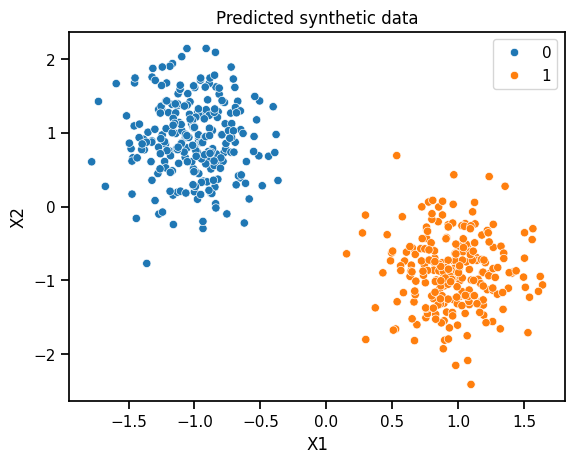

In [17]:
plot_2d_data(X_test, y_pred, "Predicted synthetic data")

In [ ]:
def plot_decision_boundary(w, X, y):
    
    # mesh grid
    h = 0.02 
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # decision function
    Z = w[0] + w[1] * xx + w[2] * yy
    Z = Z.reshape(xx.shape)
    
    # print("Z:", Z, Z.shape)
    
    plt.figure(figsize=(8, 6))
    
    # decision boundary
    plt.contourf(xx, yy, Z > 0.5, alpha=0.3)
    
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
        
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title("Decision boundary analytical")
    plt.show()

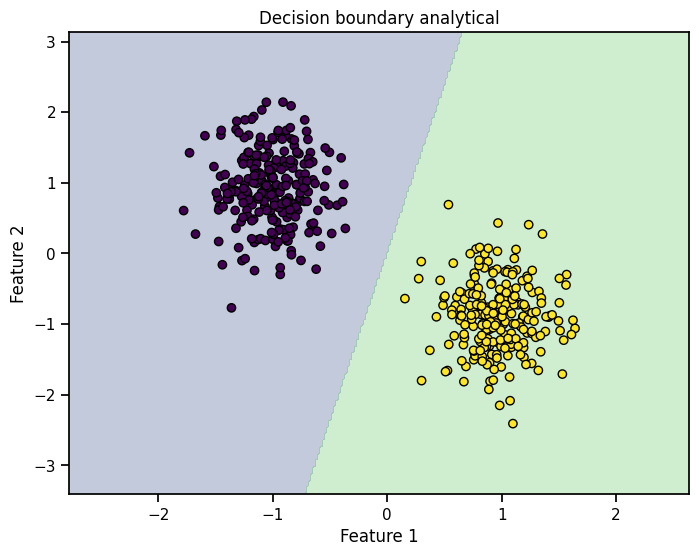

In [19]:
plot_decision_boundary(w, X_test, y_pred)

Confusion matrix analytical

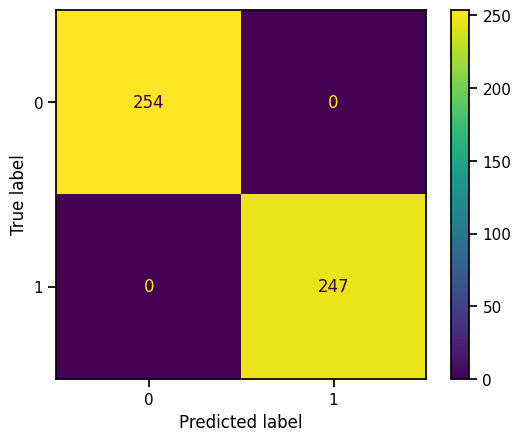

In [20]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [21]:
cr = classification_report(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn+fp) # swoistosc
sensitivity = tp / (tp+fn) # czulosc
print(cr)
print(f"specificity: {specificity}")
print(f"sensitivity: {sensitivity}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       254
           1       1.00      1.00      1.00       247

    accuracy                           1.00       501
   macro avg       1.00      1.00      1.00       501
weighted avg       1.00      1.00      1.00       501

specificity: 1.0
sensitivity: 1.0


In [22]:
fpr, tpr, thresholds = roc_curve(y_test, scores)
auc_analytical = auc(fpr, tpr)


print(f"fpr: {fpr}")
print(f"tpr: {tpr}") 
print(f"thresholds: {thresholds}") 

fpr: [0. 0. 0. 1.]
tpr: [0.         0.00404858 1.         1.        ]
thresholds: [        inf  1.27891983  0.6204122  -0.33270952]


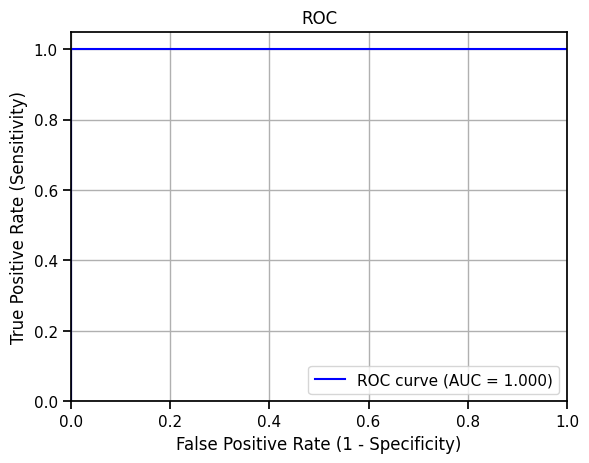

In [23]:
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc(fpr, tpr):.3f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Sklearn Ridge Classifier

In [24]:
# model training
clf = RidgeClassifier(alpha=3.0).fit(X_train, y_train) # alpha controls the regularization strength of the model

In [25]:
y_pred_sklearn = clf.predict(X_test)
scores_sklearn = clf.decision_function(X_test)
y_pred_sklearn[:5], scores_sklearn[:5]

(array([1, 0, 0, 1, 0]),
 array([ 0.86271618, -1.38314579, -0.86770518,  1.03947938, -0.5637464 ]))

In [26]:
accuracy_sklearn = clf.score(X_test, y_test)
print(f"RidgeClassifier accuracy: {accuracy_sklearn:.4f}")

RidgeClassifier accuracy: 1.0000


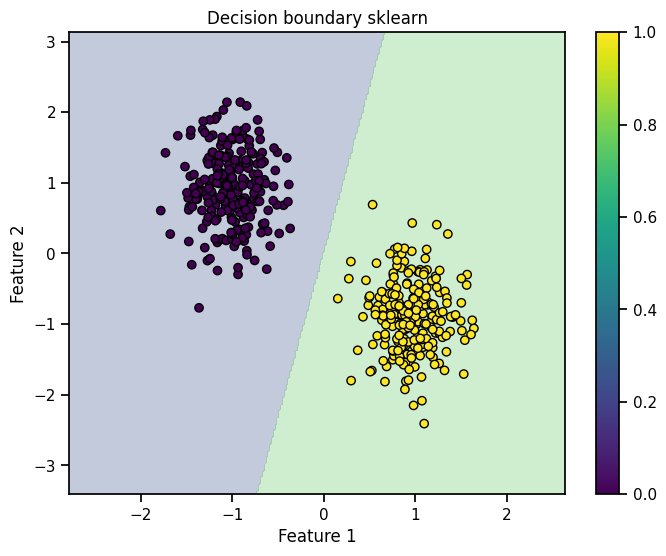

In [27]:
def plot_decision_boundary_ridge(clf, X, y):

    h = 0.02 
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(8, 6))
    
    plt.contourf(xx, yy, Z > 0, alpha=0.3)
        
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title("Decision boundary sklearn")
    plt.colorbar(scatter)
    plt.show()

plot_decision_boundary_ridge(clf, X_test, y_test)

Confusion matrix sklearn

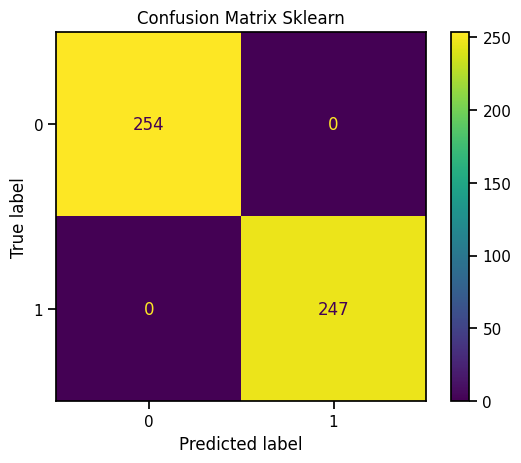

In [28]:
cm_sklearn = confusion_matrix(y_test, y_pred_sklearn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_sklearn)
disp.plot()
plt.title("Confusion Matrix Sklearn")
plt.show()

Classification raport

In [29]:
cr_sklearn = classification_report(y_test, y_pred_sklearn)
tn, fp, fn, tp = cm_sklearn.ravel()
specificity_sklearn = tn / (tn+fp)  # swoistość
sensitivity_sklearn = tp / (tp+fn)  # czułość
print(cr_sklearn)
print(f"Specificity: {specificity_sklearn}")
print(f"Sensitivity: {sensitivity_sklearn}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       254
           1       1.00      1.00      1.00       247

    accuracy                           1.00       501
   macro avg       1.00      1.00      1.00       501
weighted avg       1.00      1.00      1.00       501

Specificity: 1.0
Sensitivity: 1.0


ROC Curve

In [30]:
fpr_sklearn, tpr_sklearn, thresholds_sklearn = roc_curve(y_test, scores_sklearn)
auc_sklearn = auc(fpr_sklearn, tpr_sklearn)

print(f"fpr: {fpr_sklearn}")
print(f"tpr: {tpr_sklearn}") 
print(f"thresholds: {thresholds_sklearn}") 

fpr: [0. 0. 0. 1.]
tpr: [0.         0.00404858 1.         1.        ]
thresholds: [        inf  1.55784358  0.24214004 -1.66342595]


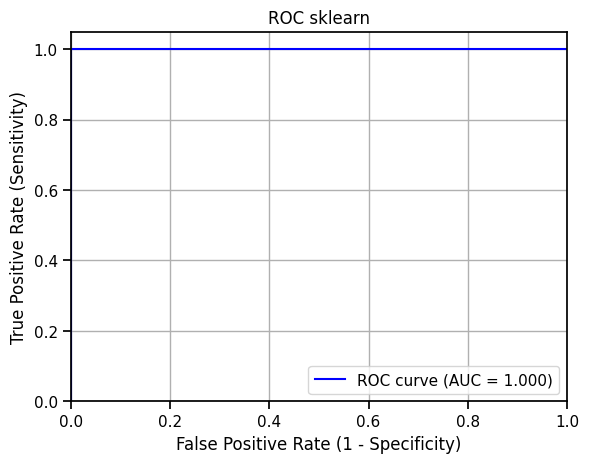

In [31]:
plt.plot(fpr_sklearn, tpr_sklearn, color='blue', label=f'ROC curve (AUC = {auc(fpr_sklearn, tpr_sklearn):.3f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC sklearn')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [32]:
start_time = time.time()
for _ in range(1000):
    w = analytical_linear_l2(X_train, y_train, 1)
analytical_time = time.time() - start_time

start_time = time.time()
for _ in range(1000):
    clf = RidgeClassifier().fit(X_train, y_train)
sklearn_time = time.time() - start_time

print(f"Analytical time: {analytical_time:.6f} s")
print(f"Sklearn time: {sklearn_time:.6f} s")

Analytical time: 0.132671 s
Sklearn time: 3.630702 s


In [33]:
comparison_data = {
    'Metric': ['Accuracy', 'Sensitivity', 'Specificity', 'AUC', 'Training Time (s)'],
    'Analytical Classifier': [accuracy, sensitivity, specificity, auc_analytical, analytical_time/1000],
    'RidgeClassifier': [accuracy_sklearn, sensitivity_sklearn, specificity_sklearn, auc_sklearn, sklearn_time/1000]
}
comparison_df = pd.DataFrame(comparison_data)
comparison_df

,Metric,Analytical Classifier,RidgeClassifier
0,Accuracy,1.000000,1.000000
1,Sensitivity,1.000000,1.000000
2,Specificity,1.000000,1.000000
3,AUC,1.000000,1.000000
4,Training Time (s),0.000133,0.003631


# Heart disease

In [34]:
from ucimlrepo import fetch_ucirepo 

heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets 
  
# metadata 
print(heart_disease.metadata) 
  
# variable information 
print(heart_disease.variables)

{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'ID': 231, 'type': 'NATIVE', 'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M

In [35]:
X.shape, y.shape

((303, 13), (303, 1))

In [36]:
X

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,1,110,264,0,0,132,0,1.2,2,0.0,7.0
299,68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0
300,57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0
301,57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0


In [37]:
y = y.iloc[:,0] # y appears to be a DataFrame rather than a Series.

In [38]:
y.shape

(303,)

Experiments with the Cleveland database have concentrated on simply attempting to distinguish presence (values 1,2,3,4) from absence (value 0).

In [39]:
y.unique()

array([0, 2, 1, 3, 4])

In [40]:
y = y.replace([2,3,4],1)
y.unique(), y.shape

(array([0, 1]), (303,))

In [41]:
nan_count = X.isnull().sum().sum()
print('Number of NaN values:', nan_count)

Number of NaN values: 6


Remove all rows with empty data

In [42]:
data = pd.concat([X, y], axis=1)

data_ = data.dropna()

X_ = data_.iloc[:, :-1] 
y_ = data_.iloc[:, -1]     # last col

X.shape, X_.shape

((303, 13), (297, 13))

sex -> 1 = male

In [43]:
stds = X_.std(axis=0)
min_val = X_.min()
max_val = X_.max()

# 1 -> int, 0 -> Categorical
types = [1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1]
modes_means = [float(X_[col].mean()) if types[i]==1 else float(X_[col].mode().iloc[0]) for i, col in enumerate(X_)]

In [44]:
stats_df = pd.DataFrame({
    'Type': ['Numeric' if types[i]==1 else 'Categorical' for i in range(len(X_.columns))],
    'Mean/Mode': [X_[col].mean() if types[i]==1 else X_[col].mode().iloc[0] for i, col in enumerate(X_.columns)],
    'Std Dev': [X_[col].std() if types[i]==1 else 'N/A' for i, col in enumerate(X_.columns)],
    'Min': X_.min(),
    'Max': X_.max()
})
stats_df

,Type,Mean/Mode,Std Dev,Min,Max
age,Numeric,54.542088,9.049736,29.0,77.0
sex,Categorical,1.000000,N/A,0.0,1.0
cp,Categorical,4.000000,N/A,1.0,4.0
trestbps,Numeric,131.693603,17.762806,94.0,200.0
chol,Numeric,247.350168,51.997583,126.0,564.0
fbs,Categorical,0.000000,N/A,0.0,1.0
restecg,Categorical,0.000000,N/A,0.0,2.0
thalach,Numeric,149.599327,22.941562,71.0,202.0
exang,Categorical,0.000000,N/A,0.0,1.0
oldpeak,Numeric,1.055556,1.166123,0.0,6.2


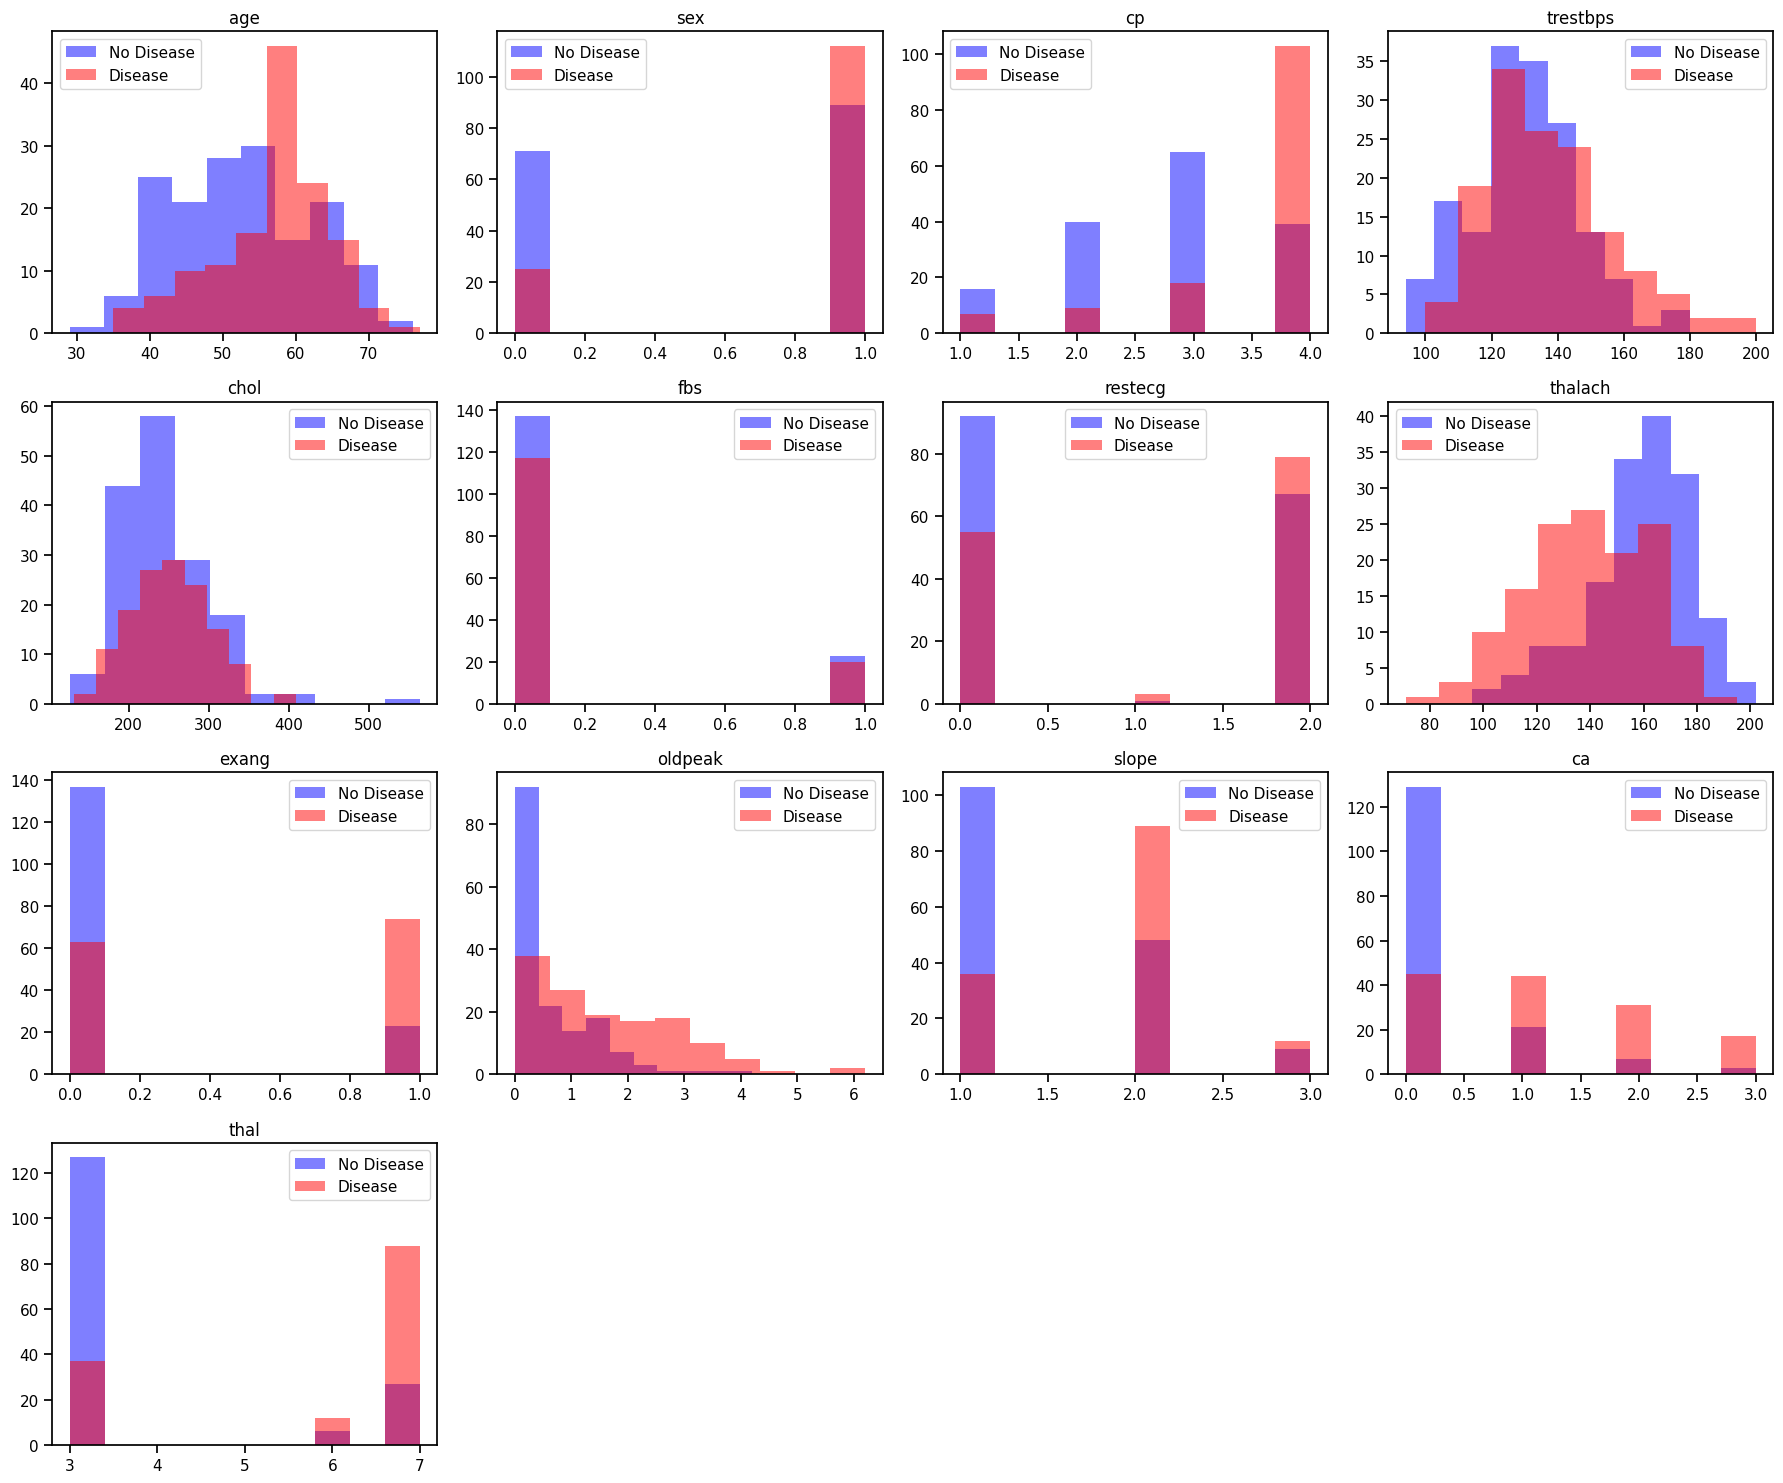

In [75]:
plt.figure(figsize=(18, 15))

for i, column in enumerate(X_.columns):
    plt.subplot(4, 4, i+1)
    for y in [0, 1]:
            subset = X_[y_ == y]
            plt.hist(subset[column], alpha=0.5, 
                     label=f'No Disease' if y == 0 else 'Disease',
                     color='blue' if y == 0 else 'red')
    plt.title(column)
    plt.legend()
    
plt.tight_layout()
plt.show()


Choosing data from histogram means looking for minimal overlap in predicted classes.

We can clearly see in the **age** feature that diseases skyrockets from the age of 60.

**Thalach** is a good candidate as we can also see not overlaping values.

In categorical features we should look for most differences in height of bars in class. Thus **cp**, **ca** and **thal** have a potential to be most influential.

In [46]:
corr_matrix = X_.corr()
corr_matrix

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
age,1.000000,-0.092399,0.110471,0.290476,0.202644,0.132062,0.149917,-0.394563,0.096489,0.197123,0.159405,0.362210,0.126586
sex,-0.092399,1.000000,0.008908,-0.066340,-0.198089,0.038850,0.033897,-0.060496,0.143581,0.106567,0.033345,0.091925,0.383652
cp,0.110471,0.008908,1.000000,-0.036980,0.072088,-0.057663,0.063905,-0.339308,0.377525,0.203244,0.151079,0.235644,0.268500
trestbps,0.290476,-0.066340,-0.036980,1.000000,0.131536,0.180860,0.149242,-0.049108,0.066691,0.191243,0.121172,0.097954,0.138183
chol,0.202644,-0.198089,0.072088,0.131536,1.000000,0.012708,0.165046,-0.000075,0.059339,0.038596,-0.009215,0.115945,0.010859
fbs,0.132062,0.038850,-0.057663,0.180860,0.012708,1.000000,0.068831,-0.007842,-0.000893,0.008311,0.047819,0.152086,0.062209
restecg,0.149917,0.033897,0.063905,0.149242,0.165046,0.068831,1.000000,-0.072290,0.081874,0.113726,0.135141,0.129021,0.018795
thalach,-0.394563,-0.060496,-0.339308,-0.049108,-0.000075,-0.007842,-0.072290,1.000000,-0.384368,-0.347640,-0.389307,-0.268727,-0.274831
exang,0.096489,0.143581,0.377525,0.066691,0.059339,-0.000893,0.081874,-0.384368,1.000000,0.289310,0.250572,0.148232,0.326927
oldpeak,0.197123,0.106567,0.203244,0.191243,0.038596,0.008311,0.113726,-0.347640,0.289310,1.000000,0.579037,0.294452,0.344976


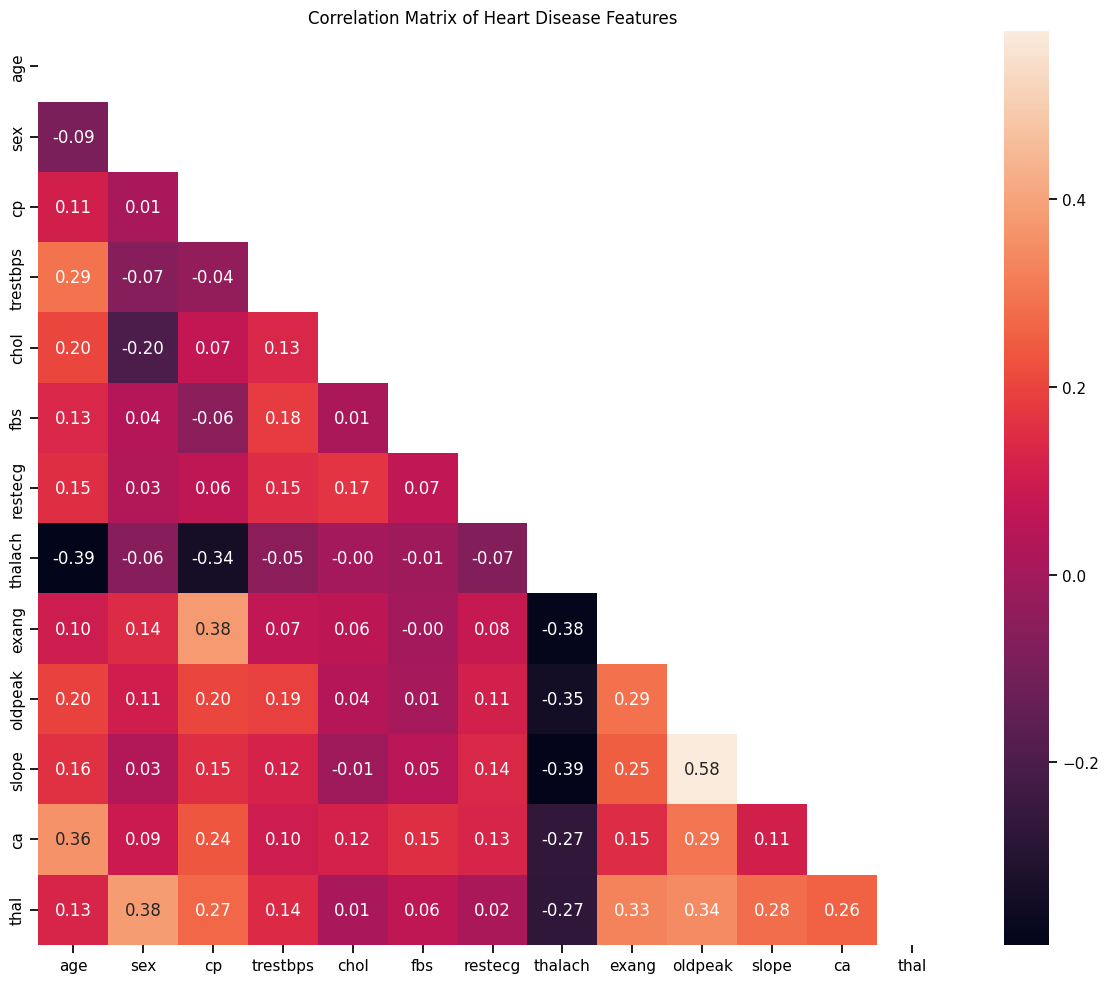

In [47]:
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f')

plt.title('Correlation Matrix of Heart Disease Features')
plt.tight_layout()
plt.show()

From the correlation matrix we should exclue **thalach**, because its strongly correlated with other featues.

In [48]:
X_train_heart, X_test_heart, y_train_heart, y_test_heart = train_test_split(
    X_, y_, test_size=0.2, random_state=259202)

In [49]:
scaler_heart = StandardScaler()
X_train_heart_ = scaler_heart.fit_transform(X_train_heart)
X_test_heart_ = scaler_heart.transform(X_test_heart)

13 features

In [50]:
ridge_all_features = RidgeClassifier(alpha=1.0)
ridge_all_features.fit(X_train_heart_, y_train_heart)
y_pred_ridge_all = ridge_all_features.predict(X_test_heart_)
scores_ridge_all = ridge_all_features.decision_function(X_test_heart_)

accuracy_ridge_all = accuracy_score(y_test_heart, y_pred_ridge_all)
cm_ridge_all = confusion_matrix(y_test_heart, y_pred_ridge_all)
tn, fp, fn, tp = cm_ridge_all.ravel()
specificity_ridge_all = tn / (tn + fp)
sensitivity_ridge_all = tp / (tp + fn)
auc_ridge_all = roc_auc_score(y_test_heart, scores_ridge_all)

In [51]:
X_train_heart_bias = np.c_[np.ones(X_train_heart_.shape[0]), X_train_heart_]
X_train_heart_bias = np.c_[np.ones(X_test_heart_.shape[0]), X_test_heart_]

w_heart_all = analytical_linear_l2(X_train_heart_, y_train_heart, 1.0)
scores_analytical_all = X_train_heart_bias @ w_heart_all
y_pred_analytical_all = np.where(scores_analytical_all > 0.5, 1, 0)

accuracy_analytical_all = accuracy_score(y_test_heart, y_pred_analytical_all)
cm_analytical_all = confusion_matrix(y_test_heart, y_pred_analytical_all)
tn, fp, fn, tp = cm_analytical_all.ravel()
specificity_analytical_all = tn / (tn + fp)
sensitivity_analytical_all = tp / (tp + fn)
auc_analytical_all = roc_auc_score(y_test_heart, scores_analytical_all)

In [52]:
print(f"RidgeClassifier: Accuracy={accuracy_ridge_all:.4f}, Sensitivity={sensitivity_ridge_all:.4f}, Specificity={specificity_ridge_all:.4f}, AUC={auc_ridge_all:.4f}")
print(f"Analytical: Accuracy={accuracy_analytical_all:.4f}, Sensitivity={sensitivity_analytical_all:.4f}, Specificity={specificity_analytical_all:.4f}, AUC={auc_analytical_all:.4f}")
print("\nRidgeClassifier:")
print(classification_report(y_test_heart, y_pred_ridge_all))
print("\nAnalytical Classifier:")
print(classification_report(y_test_heart, y_pred_analytical_all))

RidgeClassifier: Accuracy=0.8667, Sensitivity=0.7667, Specificity=0.9667, AUC=0.9178
Analytical: Accuracy=0.8667, Sensitivity=0.7667, Specificity=0.9667, AUC=0.9178

RidgeClassifier:
              precision    recall  f1-score   support

           0       0.81      0.97      0.88        30
           1       0.96      0.77      0.85        30

    accuracy                           0.87        60
   macro avg       0.88      0.87      0.87        60
weighted avg       0.88      0.87      0.87        60


Analytical Classifier:
              precision    recall  f1-score   support

           0       0.81      0.97      0.88        30
           1       0.96      0.77      0.85        30

    accuracy                           0.87        60
   macro avg       0.88      0.87      0.87        60
weighted avg       0.88      0.87      0.87        60



In [66]:
# Automatic feature selection
sfs = SequentialFeatureSelector(
    estimator=RidgeClassifier(alpha=1.0),
    n_features_to_select=4,
    direction='forward', # forward selection -> add features
    cv=5 # 5-fold cross-validation (default)
)

sfs.fit(X_train_heart_, y_train_heart) 
selected_features_mask = sfs.get_support() # True/False mask for selected features
selected_features = X_.columns[selected_features_mask].tolist()

print(f"\nAutomatically selected features: {selected_features}")


Automatically selected features: ['cp', 'exang', 'ca', 'thal']


In [62]:
manual_features = ['age', 'cp', 'ca', 'thal']

Większość cech wybrana automatycznie jest podobna do tych wybranych manualnie.

In [63]:
X_train_auto = X_train_heart_[:, selected_features_mask]
X_test_auto = X_test_heart_[:, selected_features_mask]

manual_features_mask = np.array([col in manual_features for col in X_.columns])
X_train_manual = X_train_heart_[:, manual_features_mask]
X_test_manual = X_test_heart_[:, manual_features_mask]

In [76]:
def evaluate_classifiers(X_train, X_test, y_train, y_test):

    ridge_model = RidgeClassifier(alpha=1.0)
    ridge_model.fit(X_train, y_train)
    y_pred_ridge = ridge_model.predict(X_test)
    scores_ridge = ridge_model.decision_function(X_test)
    

    accuracy_ridge = accuracy_score(y_test, y_pred_ridge)
    cm_ridge = confusion_matrix(y_test, y_pred_ridge)
    tn, fp, fn, tp = cm_ridge.ravel()
    specificity_ridge = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity_ridge = tp / (tp + fn) if (tp + fn) > 0 else 0
    auc_ridge = roc_auc_score(y_test, scores_ridge)
    

    X_train_with_bias = np.c_[np.ones(X_train.shape[0]), X_train]
    X_test_with_bias = np.c_[np.ones(X_test.shape[0]), X_test]
    
    w_analytical = analytical_linear_l2(X_train, y_train, 1.0)
    scores_analytical = X_test_with_bias @ w_analytical
    y_pred_analytical = np.where(scores_analytical > 0.5, 1, 0)
    

    accuracy_analytical = accuracy_score(y_test, y_pred_analytical)
    cm_analytical = confusion_matrix(y_test, y_pred_analytical)
    tn, fp, fn, tp = cm_analytical.ravel()
    specificity_analytical = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity_analytical = tp / (tp + fn) if (tp + fn) > 0 else 0
    auc_analytical = roc_auc_score(y_test, scores_analytical)
    
    print(f"RidgeClassifier: Accuracy={accuracy_ridge:.4f}, Sensitivity={sensitivity_ridge:.4f}, Specificity={specificity_ridge:.4f}, AUC={auc_ridge:.4f}")
    print(f"Analytical: Accuracy={accuracy_analytical:.4f}, Sensitivity={sensitivity_analytical:.4f}, Specificity={specificity_analytical:.4f}, AUC={auc_analytical:.4f}")
    

print("\nSequentialFeatureSelector")
evaluate_classifiers(X_train_auto, X_test_auto, y_train_heart, y_test_heart)

print("\nManually selected features")
evaluate_classifiers(X_train_manual, X_test_manual, y_train_heart, y_test_heart)


SequentialFeatureSelector
RidgeClassifier: Accuracy=0.8833, Sensitivity=0.8000, Specificity=0.9667, AUC=0.9156
Analytical: Accuracy=0.8833, Sensitivity=0.8000, Specificity=0.9667, AUC=0.9156

Manually selected features
RidgeClassifier: Accuracy=0.8500, Sensitivity=0.7667, Specificity=0.9333, AUC=0.8994
Analytical: Accuracy=0.8500, Sensitivity=0.7667, Specificity=0.9333, AUC=0.8994
